In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/AnomalyDetection

/content/drive/MyDrive/AnomalyDetection


In [44]:
import torch
from common import get_autoencoder, get_pdn_small, get_pdn_medium, ImageFolderWithoutTarget, InfiniteDataloader
from efficientad import map_normalization, teacher_normalization, train_transform, default_transform, predict
import torch.nn.functional as F
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np


In [45]:
def load_models(model_dir, model_size='small', out_channels=384):
    """
    Load and prepare the teacher, student, and autoencoder models for inference.

    Args:
        model_dir (str): Directory containing the model weights.
        model_size (str): Size of the model ('small' or 'medium').
        out_channels (int): Number of output channels.

    Returns:
        tuple: (teacher, student, autoencoder) models ready for inference.
    """
    # Check if GPU is available
    on_gpu = torch.cuda.is_available()
    device = 'cuda' if on_gpu else 'cpu'
    print(f"Loading models on: {'GPU' if on_gpu else 'CPU'}")

    # Create models based on size
    if model_size == 'small':
        teacher = get_pdn_small(out_channels)
        student = get_pdn_small(2 * out_channels)
    elif model_size == 'medium':
        teacher = get_pdn_medium(out_channels)
        student = get_pdn_medium(2 * out_channels)
    else:
        raise ValueError("Model size must be 'small' or 'medium'")

    autoencoder = get_autoencoder(out_channels)

    try:
        # Load all model weights using weights_only=True to avoid pickle warning
        teacher = torch.load(os.path.join(model_dir, 'teacher_final.pth'), map_location=device, weights_only=False)
        student = torch.load(os.path.join(model_dir, 'student_final.pth'), map_location=device, weights_only=False)
        autoencoder = torch.load(os.path.join(model_dir, 'autoencoder_final.pth'), map_location=device, weights_only=False)

        # Move models to appropriate device
        if on_gpu:
            teacher = teacher.cuda()
            student = student.cuda()
            autoencoder = autoencoder.cuda()

        # Set models to evaluation mode
        teacher.eval()
        student.eval()
        autoencoder.eval()

        return teacher, student, autoencoder

    except FileNotFoundError as e:
        print(f"Error loading models: {e}")
        print(f"Please ensure all model files exist in directory: {model_dir}")
        print("Required files: teacher_final.pth, student_final.pth, autoencoder_final.pth")
        raise




def load_data_and_normalize_maps(teacher,student, autoencoder, dataset_path, subdataset, image_size, batch_size=1, seed=42):
    # Set up transformations for the images
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load the training data
    train_set = ImageFolderWithoutTarget(
        os.path.join(dataset_path, subdataset, 'train'),
        transform=transforms.Lambda(train_transform))

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)


    # Normalize the teacher model using the training data
    teacher_mean, teacher_std = teacher_normalization(teacher, train_loader)

    # Perform map normalization
    q_st_start, q_st_end, q_ae_start, q_ae_end = map_normalization(
        validation_loader=train_loader, teacher=teacher,
        student=student, autoencoder=autoencoder,
        teacher_mean=teacher_mean, teacher_std=teacher_std,
        desc='Map normalization for teacher'
    )

    return q_st_start, q_st_end, q_ae_start, q_ae_end, teacher_mean, teacher_std






def visualize_prediction_maps_separately(image, map_combined, map_st, map_ae, cmap='viridis'):
    """
    Visualize and save separate heatmaps generated by the predict function, alongside the input image.

    Args:
        image (torch.Tensor): The original input image (1, 3, H, W) or (3, H, W).
        map_combined (torch.Tensor): Combined map output of predict function.
        map_st (torch.Tensor): Student-Teacher map output of predict function.
        map_ae (torch.Tensor): Autoencoder map output of predict function.
        cmap (str): Colormap for the heatmaps.
    """
    def process_map(map_tensor):
        """Remove batch and channel dimensions and normalize to [0, 1]."""
        map_array = map_tensor.squeeze().cpu().numpy()  # Squeeze (1, 1, H, W -> H, W)
        map_array = (map_array - map_array.min()) / (map_array.max() - map_array.min())  # Normalize to [0, 1]
        return map_array

    def process_image(image_tensor):
        """Process the image for visualization."""
        if image_tensor.ndim == 4:  # (B, C, H, W)
            image_tensor = image_tensor.squeeze(0)  # Remove batch dimension
        image_np = image_tensor.permute(1, 2, 0).cpu().numpy()  # (C, H, W -> H, W, C)
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize to [0, 1]
        return image_np

    # Process inputs
    image_processed = process_image(image)
    map_combined_processed = process_map(map_combined)
    map_st_processed = process_map(map_st)
    map_ae_processed = process_map(map_ae)

    # Display original image
    plt.figure(figsize=(6, 6))
    plt.imshow(image_processed)
    plt.title("Original Image")
    plt.axis("off")
    plt.savefig("original_image.png")
    plt.show()

    # Combined map
    plt.figure(figsize=(6, 6))
    plt.imshow(map_combined_processed, cmap=cmap)
    plt.colorbar(label="Normalized Intensity")
    plt.title("Combined Map")
    plt.axis("off")
    plt.savefig("combined_map.png")
    plt.show()

    # Student-Teacher map
    plt.figure(figsize=(6, 6))
    plt.imshow(map_st_processed, cmap=cmap)
    plt.colorbar(label="Normalized Intensity")
    plt.title("Student-Teacher Map")
    plt.axis("off")
    plt.savefig("student_teacher_map.png")
    plt.show()

    # Autoencoder map
    plt.figure(figsize=(6, 6))
    plt.imshow(map_ae_processed, cmap=cmap)
    plt.colorbar(label="Normalized Intensity")
    plt.title("Autoencoder Map")
    plt.axis("off")
    plt.savefig("autoencoder_map.png")
    plt.show()


In [46]:

image_path = "/content/drive/MyDrive/Datasets/Real-IAD/plastic_nut/test/AK/plastic_nut_0001_NG_AK_C4_20231004132101.png"
image = Image.open(image_path).convert('RGB')
image = default_transform(image)
image = image[None]  # Add batch dimension
if torch.cuda.is_available():
    image = image.cuda()
print("Image loaded successfully!")



teacher, student, autoencoder = load_models(
    model_dir='/content/drive/MyDrive/AnomalyDetection/output/plustic_nut_modemini/trainings/mvtec_ad/plastic_nut',
    model_size='small'
)
print("Models loaded successfully!")





# map normalization
dataset_path = '/content/drive/MyDrive/Datasets/Real-IAD'  # Your dataset path
subdataset = 'plastic_nut'  # Example subdataset
image_size = 256  # Size to which images are resized

q_st_start, q_st_end, q_ae_start, q_ae_end, teacher_mean, teacher_std = load_data_and_normalize_maps(teacher,student, autoencoder,dataset_path, subdataset, image_size)
print(f"Map Normalization Results:\nq_st_start: {q_st_start}\nq_st_end: {q_st_end}\nq_ae_start: {q_ae_start}\nq_ae_end: {q_ae_end}")





Image loaded successfully!
Loading models on: GPU
Models loaded successfully!


Map normalization for teacher: 100%|██████████| 2258/2258 [00:46<00:00, 48.51it/s]

Map Normalization Results:
q_st_start: 0.07361620664596558
q_st_end: 0.08122812956571579
q_ae_start: 0.02714187279343605
q_ae_end: 0.08480735868215561


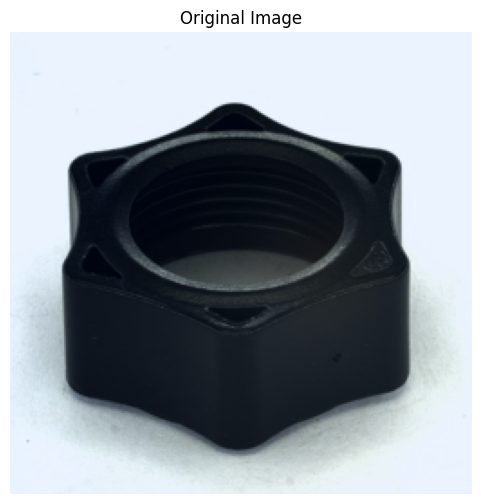

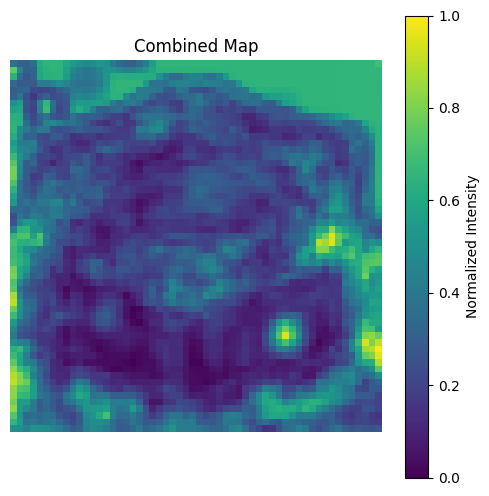

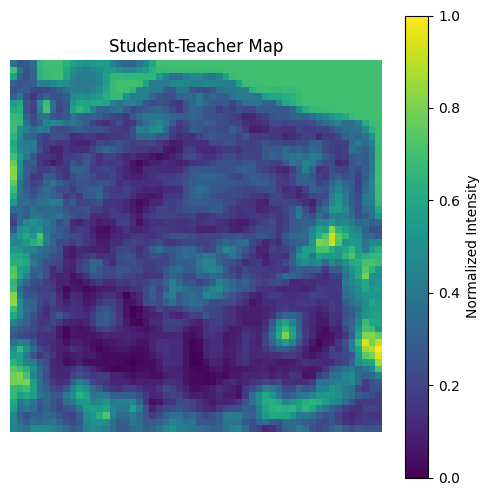

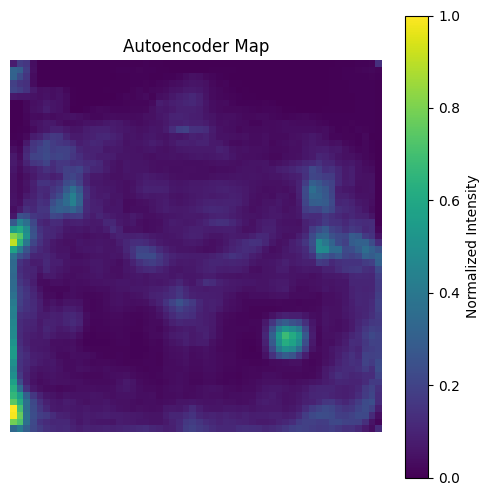

In [47]:

map_combined, map_st, map_ae = predict(
            image=image, teacher=teacher, student=student,
            autoencoder=autoencoder, teacher_mean=teacher_mean,
            teacher_std=teacher_std, q_st_start=q_st_start, q_st_end=q_st_end,
            q_ae_start=q_ae_start, q_ae_end=q_ae_end)
# Example usage
# Assuming map_combined, map_st, and map_ae are outputs from the predict function
visualize_prediction_maps_separately(image, map_combined, map_st, map_ae)
